# LCFS technical analysis

Geo Zhang | Department of Energy Science & Engineering, Stanford University

## Table of Content
- (a) Kalman Fitering
- (b) ARIMA
- (c) XGBoost
- (d) Prophet
- (e) LSTM
- (f) TFT
- (...) with trading volume
- Extension: To incorporate sentimental scores

In [ ]:
# !pip install pandas
# !pip install pmdarima
# !pip install matplotlib statsmodels
# !pip install transformers
# !pip install pytorch-forecasting pytorch-lightning torch
#!pip install xgboost
#!pip install filterpy
#!pip install darts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error, f1_score
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

In [ ]:
path_to_data = "LCFS_task/LCFS_monthly.csv "
lcfs = pd.read_csv('./LCFS_task/LCFS_monthly.csv', usecols=['Date', 'Price', 'Volume'])

lcfs['Date'] = pd.to_datetime(lcfs['Date'])
lcfs

,Date,Price,Volume
0,2013-01-13,22.0,24000
1,2013-02-13,27.0,36000
2,2013-03-13,34.0,48000
3,2013-04-13,35.0,42000
4,2013-05-13,45.0,7000
...,...,...,...
137,2024-06-24,51.0,1543000
138,2024-07-24,57.0,6283000
139,2024-08-24,54.0,2155000
140,2024-09-24,60.0,3022000


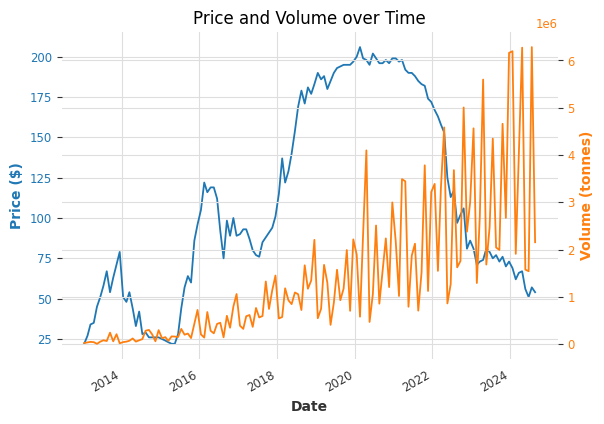

In [ ]:
# Creating a plot with two y-axes
fig, ax1 = plt.subplots()

# Plotting the Price on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)', color='tab:blue')
ax1.plot(lcfs['Date'], lcfs['Price'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a second y-axis for the Volume
ax2 = ax1.twinx()
ax2.set_ylabel('Volume (tonnes)', color='tab:orange')
ax2.plot(lcfs['Date'], lcfs['Volume'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Formatting the x-axis to show date labels properly
fig.autofmt_xdate()

# Adding a title to the plot
plt.title('Price and Volume over Time')

plt.savefig('./tech_results/Price+volume.png', dpi = 300)

# Showing the plot
plt.show()

# Evaluation metric

In [ ]:
def evaluation(y_pred, y):
    # Mean standard error
    mse = np.sum((y_pred - y)**2.0)

    # Mean prediction accuracy
    within_threshold = np.abs(y_pred - y) / y
    mpa = np.mean(1 - within_threshold) * 100  # convert to percentage

    true_trend = np.sign(np.diff(y))  # +1 for upward, -1 for downward
    predicted_trend = np.sign(np.diff(y_pred))

    # F-1 Score
    f1 = f1_score(true_trend, predicted_trend, average='macro')

    # movement direction accuracy
    correct_trend = true_trend == predicted_trend
    mda = np.mean(correct_trend) * 100  # convert to percentage

    return {
        'MSE': mse,
        'MPA (%)': mpa,
        'F1 Score': f1,
        'MDA (%)': mda}


# Technical Analysis

In [ ]:
prices = lcfs['Price'].values

## (a) Kalman Filtering

1. Prediction: State Equation (Estimates the next state based on the previous state)
   $$ x_t = F \cdot x_{t-1} + G \cdot u_t + w_t $$
3. Update: Observation Equation (Incorporates observed data to correct the predicted state)
   $$ z_t = H \cdot x_t + v_t $$
    
   

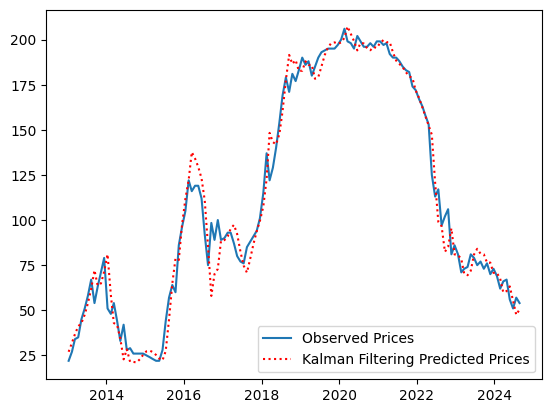

{'MSE': 13036.503068634483,
 'MPA (%)': 91.26611510698807,
 'F1 Score': 0.3645342312008979,
 'MDA (%)': 52.51798561151079}

In [ ]:
# Define Kalman Filter parameters
kf = KalmanFilter(dim_x=3, dim_z=1)

# Initial state (price and velocity)
kf.x = np.array([prices[0], 5., 0.])  # Initialization

# State transition matrix (how state evolves)
kf.F = np.array([[1., 1., 0.5],
                 [0., 1., 1.],
                 [0., 0., 1.]])  # Assumes constant velocity

# Observation matrix (how we map the state to the observation)
kf.H = np.array([[1., 0., 0.]])  # We only observe the price

# Process uncertainty (noise in the system)
kf.P *= 0  # Initial uncertainty

# Measurement noise
kf.R = 1  # Adjust based on your noise level in the price data

# Process noise covariance (how much we trust our model)
kf.Q = np.array([[1., 0., 0.],
                 [0., 1., 0.],
                 [0., 0., 1.]]) * 0.01

# Perform Kalman filtering
predicted_prices = []
for z in prices:
    kf.predict()  # Predict the next state
    predicted_prices.append(kf.x[0])  # Store the predicted price
    kf.update([z])  # Update with the observed price

# Plot original vs. predicted prices
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'], predicted_prices, label='Kalman Filtering Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.show()

evaluation(predicted_prices, prices)

In [ ]:
def kalman_filter_with_hyperparams(true_prices, Q, R, P_0, v0, a0, dt):
    # Kalman Filter initialization (assuming 3D state: price, velocity, and acceleration)
    kf = KalmanFilter(dim_x=3, dim_z=1)

    kf.x = np.array([true_prices[0], v0, a0])  # Initial state: price, velocity, and acceleration

    # Initialize state covariancbe, process noise, and measurement noise
    kf.P *= P_0                                 # Initial uncertainty
    kf.F = np.array([[1., dt, 0.5*dt**2.],
                     [0., 1., dt],
                     [0., 0., 1.]])             # State transition matrix

    kf.H = np.array([[1., 0., 0.]])             # Observation matrix
    kf.R = np.array([[R]])                      # Measurement noise covariance
    kf.Q = np.array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]]) * Q

    predicted_prices = []

    for z in true_prices:
        kf.predict()
        predicted_prices.append(kf.x[0])
        # Update the price using new measurement
        kf.update([z])

    return np.array(predicted_prices)

In [ ]:
# Function to evaluate the Kalman filter using different hyperparameters
def grid_search_kalman(true_prices, Q_values, R_values, P_0_values, v_0_values, a_0_values, dt_values):
    best_params = None
    best_score =  0

    for Q in Q_values:
        for R in R_values:
            for P_0 in P_0_values:
                for v_0 in v_0_values:
                    for a_0 in a_0_values:
                        for dt in dt_values:
                            predicted_prices = kalman_filter_with_hyperparams(true_prices, Q, R, P_0, v_0, a_0, dt)
                            scores = evaluation(predicted_prices, prices)
                            MSE = scores['MSE']
                            MPA = scores['MPA (%)']
                            F1  = scores['F1 Score']
                            MDA = scores['MDA (%)']

                            #if MSE < best_score:     # switch to other scores
                            if MDA > best_score:
                                best_score = MDA
                                best_params = {'Q': Q, 'R': R, 'P_0': P_0, 'v_0': v_0, 'a_0': a_0, 'dt': dt}

    return best_params, best_score

# Example Usage:
# true_prices = np.array([...])  # your true price array
Q_values = [0.01, 0.1, 1, 10, 20]
R_values = [0.1, 1, 5, 10]
P_0_values = [0.1, 1, 10]
v_0_values = [0, 1, 5, 10, 20]
a_0_values = [0, 0.1, 1, 10]
dt_values  = [0.1, 1, 5, 10]

best_params, best_score = grid_search_kalman(prices, Q_values, R_values, P_0_values, v_0_values, a_0_values, dt_values)
print(f"Best Parameters: {best_params}, Best Score: {best_score}")

Best Parameters: {'Q': 0.1, 'R': 5, 'P_0': 0.1, 'v_0': 20, 'a_0': 0, 'dt': 0.1}, Best Score: 58.992805755395686


### BEST MSE

In [ ]:
# Best Kalman Filtering model Parameters:
# Best Parameters: {'Q': 10, 'R': 1, 'P_0': 0.1, 'v_0': 20, 'a_0': 0, 'dt': 0.1}, Best Score: 10767.118153905794

Parameters = {'Q': 10, 'R': 1, 'P_0': 0.1, 'v_0': 20, 'a_0': 0, 'dt': 0.1}

Q = Parameters['Q']
R = Parameters['R']
P_0 = Parameters['P_0']
v_0 = Parameters['v_0']
a_0 = Parameters['a_0']
dt = Parameters['dt']


predicted_prices_mse = kalman_filter_with_hyperparams(prices, Q, R, P_0, v_0, a_0, dt)

dates = lcfs['Date']
df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices_mse
})

df_predictions.to_csv('tech_results/kalman_pred_mse.csv', index=False)
# # ---------------
# # Plot original vs. predicted prices
# plt.plot(lcfs['Date'], prices, label='Observed Prices')
# plt.plot(lcfs['Date'], predicted_prices, label='Kalman Filtering Predicted Prices', color='r', linestyle=':')
# plt.legend()
# plt.show()

evaluation(predicted_prices_mse, prices)


{'MSE': 10767.118153905794,
 'MPA (%)': 91.68831401141331,
 'F1 Score': 0.3436901947540245,
 'MDA (%)': 49.64028776978417}

### BEST MDA

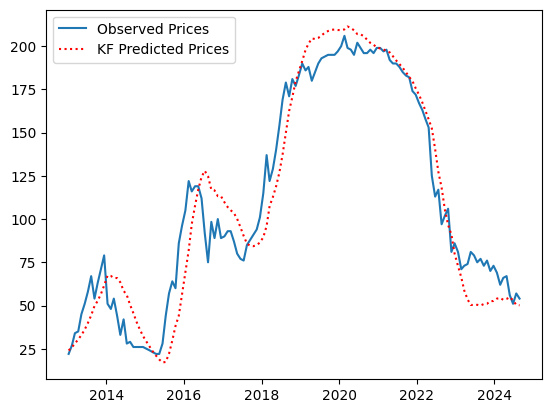

{'MSE': 43273.52868483684,
 'MPA (%)': 81.54464468054545,
 'F1 Score': 0.4094863142107237,
 'MDA (%)': 58.992805755395686}

In [ ]:
# Best Kalman Filtering model Parameters:
# Best Parameters: {'Q': 0.1, 'R': 5, 'P_0': 0.1, 'v_0': 20, 'a_0': 0, 'dt': 0.1}, Best Score: 58.992805755395686

Parameters = {'Q': 0.1, 'R': 5, 'P_0': 0.1, 'v_0': 20, 'a_0': 0, 'dt': 0.1}

Q = Parameters['Q']
R = Parameters['R']
P_0 = Parameters['P_0']
v_0 = Parameters['v_0']
a_0 = Parameters['a_0']
dt = Parameters['dt']


predicted_prices_mda = kalman_filter_with_hyperparams(prices, Q, R, P_0, v_0, a_0, dt)

dates = lcfs['Date']
df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices_mda
})

df_predictions.to_csv('tech_results/kalman_pred_mda.csv', index=False)

# # ---------------
# # Plot original vs. predicted prices
# plt.plot(lcfs['Date'], prices, label='Observed Prices')
# plt.plot(lcfs['Date'], predicted_prices, label='Kalman Filtering Predicted Prices', color='r', linestyle=':')
# plt.legend()
# plt.show()

# Plot original vs. predicted prices
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'], predicted_prices_mda, label='KF Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/KF_pred.png', dpi=300)
plt.show()


evaluation(predicted_prices_mda, prices)


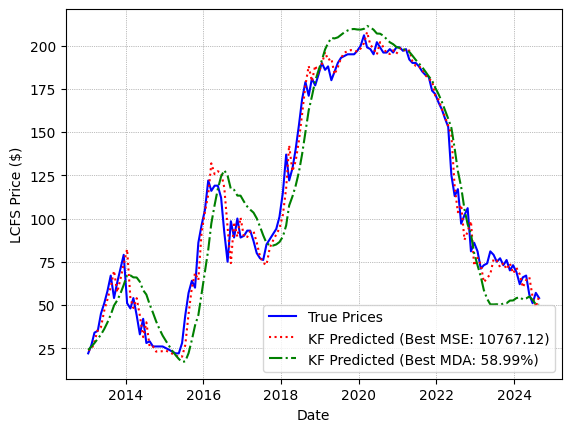

In [ ]:
# ---------------
# Plot original vs. predicted prices

plt.plot(lcfs['Date'], prices, label='True Prices', color = 'blue')
plt.plot(lcfs['Date'], predicted_prices_mse, label='KF Predicted (Best MSE: 10767.12)', color='red', linestyle=':')
plt.plot(lcfs['Date'], predicted_prices_mda, label='KF Predicted (Best MDA: 58.99%)', color='green', linestyle='-.')
plt.grid(True, color='gray', linestyle=':', linewidth=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('LCFS Price ($)')
plt.savefig('./tech_results/KF_pred.png', dpi=300)
plt.show()

## (b) ARIMA

Algorithm of ARIMA (AutoRegressive Integrated Moving Average)

There are three parts:
- AutoRegressive (AR)
- Integrated (I)
- Moving Average (MA)

**Steps**:

1. Data in chronological order (no missing value or handle missing value appropriately)
2. Check for stationarity (ARIMA requires the data to be stationary. Stationarity means that the statistical properties of the series (such as mean and variance) are constant over time)
    1. Visual Inspection: Plot the time series and observe if it has any trend or seasonality.
    2. Augmented Dickey-Fuller (ADF) Test: This statistical test determines if the time series is stationary or not. A p-value less than 0.05 usually indicates stationarity.
3. Differencing the series (integration)
4. Determine AR and MA orders using ACF/PACF
5. Fit ARIMA model with chosen (p, d, q) parameters
6. Make predictions (one-step or multi-step)
7. Evaluate model performance using metrics like MAE, MSE, RMSE
8. Refine the model (adjust ARIMA parameters or use auto-ARIMA)
9. Make rolling forecasts if needed for continuous prediction
10. Check residual diagnostics to ensure the model fits well



**Autoregressive (AR) Model** (hyperparameter **p**)

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + ... + \phi_p y_{t-p} + \epsilon_t
$$

Fitting to determine $\phi_i$

**Moving Average (MA) Model** (hyperparameter **q**)

$$
y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}
$$

Fitting to determine $\theta_i$

**Integrated (I) Part**

-- Perform differencing, **d** means the differencing steps to make the series stationary


**ARIMA Model (Combining AR, I, and MA)**

$$
y_{t}^{'} = c + \phi_{1} y_{t-1}^{'} + \phi_{2} y_{t-2}^{'} + ... + \phi_{p} y_{t-p}^{'} + \epsilon_t + \theta_{1} \epsilon_{t-1} + \theta_{2} \epsilon_{t-2} + ...+ \theta_{q} \epsilon_{t-q}
$$

where **AR** part models the dependency on previous values and **MA** part models the dependency on past forecast errors.



### Check stationary of the data

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.379277446545143
p-value: 0.5921694700491663


In [ ]:
# 1st order differencing:
result = adfuller(np.diff(prices))
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.761337729729125
p-value: 6.444529823458798e-05


In [ ]:
# 2nd order differencing:
result = adfuller(np.diff(np.diff(prices)))
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -8.866705999926893
p-value: 1.4339538806486816e-14


### Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF) plots

In [ ]:
data = np.diff(prices)

<Figure size 1000x500 with 0 Axes>

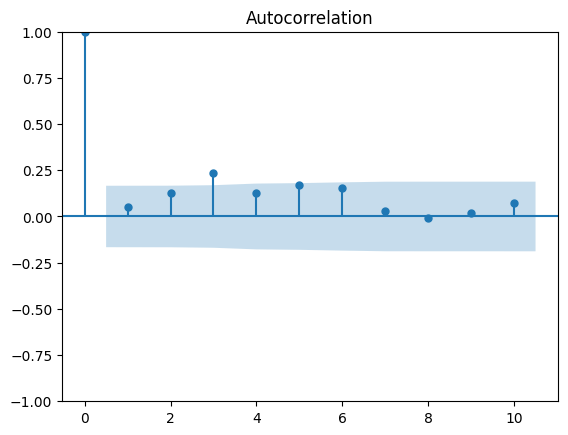

<Figure size 1000x500 with 0 Axes>

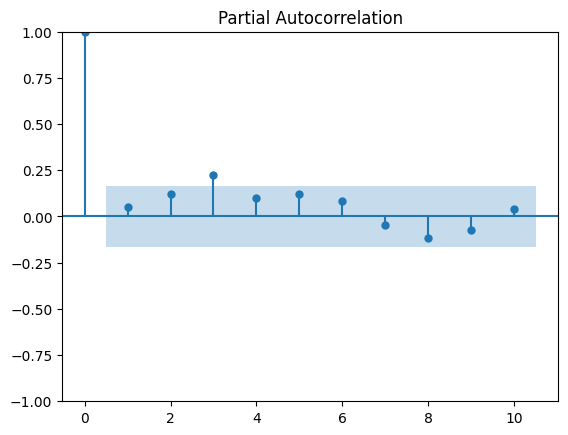

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Suppose `data` is your time series data

# ACF plot (for identifying MA(q))
plt.figure(figsize=(10, 5))
plot_acf(data, lags=10)  # Adjust 'lags' depending on the length of your data
plt.show()

# PACF plot (for identifying AR(p))
plt.figure(figsize=(10, 5))
plot_pacf(data, lags=10)
plt.show()


Comment: Due to LCFS data being nonstationary, it exhibits changing statistical properties over time. The first order already makes good stationary.

### Differencing the series (Integration - I)

- First-order differencing: $y_t^{'} = y_t - y_{t-1}$
- Second-order differencig: $y_t^{''} = y_t^{'} - y_{t-1}^{'}$
- ...

In [ ]:
from pmdarima import auto_arima

# Automatically choose the best ARIMA parameters
model = auto_arima(prices, start_p=1, start_q=1,
                   max_p=5, max_q=5, seasonal=False,
                   trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=996.329, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1083.650, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1038.208, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=995.629, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1081.653, Time=0.00 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=995.855, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=997.596, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=993.905, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=994.458, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=993.966, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1036.213, Time=0.00 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=995.696, Time=0.02 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.172 seconds
                               SARIMAX Results                                
Dep. Variable:   

In [ ]:
def rolling_ARIMA(prices, start, p, d, q):
    history = prices[:start]
    predictions = []

    for t in range(start, len(prices)):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()
        # Make a one-step prediction
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
        # Add the predicted point to the history (expanding window)
        history = np.append(history, prices[t])

    return predictions

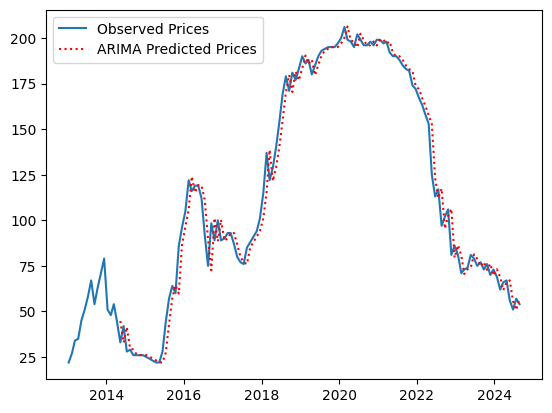

{'MSE': 9201.026872644026, 'MPA (%)': 92.8849875012283, 'F1 Score': 0.3517471364361316, 'MDA (%)': 50.40650406504065}


In [ ]:
start = 16

predicted_prices = rolling_ARIMA(prices, start, 0, 1, 1)

# Plot original vs. predicted prices
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start:], predicted_prices, label='ARIMA Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/ARIMA_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start:]))

In [ ]:
dates = lcfs['Date'][start:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices
})

df_predictions.to_csv('tech_results/ARIMA_pred.csv', index=False)

## (c) XGBoost
We also try to use XGBoot to make a regression and prediction here.

In [ ]:
def rolling_XGB(data, start, num_lags, n, m):
    x_train = []
    y_train = []

    x_test = []
    y_test = []

    predictions = []

    # construct the initial prediction
    for i in range(start - num_lags):
        x_train.append(data[i:i + num_lags])
        y_train.append(data[i+ num_lags])

    x_train = np.array(x_train)
    # y_train = np.array(y_train)
    y_train = np.array(y_train)


    # make a rolling fitting and predictions
    for i in range(start, len(data)):
        x_test = [data[i-num_lags: i]]
        y_test = data[i]

        model = XGBRegressor(random_state = 0, n_estimators = n, max_depth = m)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        predictions.append(y_pred.item())

        # Add the predicted point to the training set
        x_train = np.concatenate((x_train, x_test), axis=0)
        y_train = np.append(y_train, y_test)

    return predictions

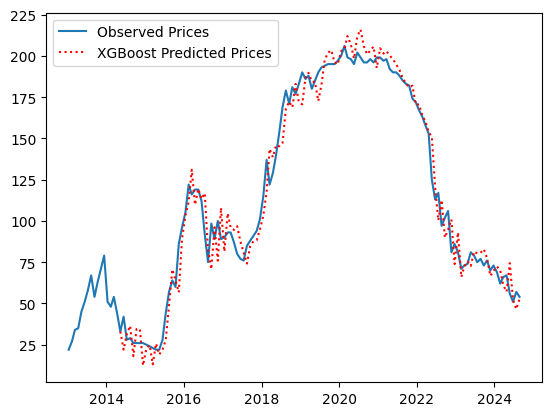

{'MSE': 13501.680731823813, 'MPA (%)': 90.2429150274236, 'F1 Score': 0.35168550178692165, 'MDA (%)': 50.40650406504065}


In [ ]:
price_start  = prices[start]
price_change = np.diff(prices)

start    = 16
num_lags = 15 # Increasing number of lags is useful to increase the score

predicted_diff = rolling_XGB(price_change, start, num_lags, n = 20, m = 20)

predicted_prices = []
predicted_prices.append(price_start)

for i in range(len(predicted_diff)):
    predicted_prices.append(prices[start+i]+predicted_diff[i])

plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start:], predicted_prices, label='XGBoost Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/XGBoost_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start:]))

In [ ]:
dates = lcfs['Date'][start:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices
})

df_predictions.to_csv('tech_results/XGBoost_pred.csv', index=False)

## (d) Facebook Prophet

$$
y(t) = g(t) + s(t) + h(t) + \epsilon_t
$$

- $y(t)$: Observed value at time t
- $g(t)$: Trend function (models long-term changes in the data)
- $s(t)$: Seasonal component (models periodic patterns, e.g., weekly, yearly)
- $h(t)$: Holiday effect (models special events or holidays that influence the data)
- $\epsilon_t$: Residuals (noise or error)

$g(t)$ supports the linear trend or logistic trend.

$s(t)$ (Seasonality) as a Fourier series to capture periodic patterns.

$h(t)$ Holiday Effects as binary indicator $\delta_i(t)$.

Residuals, $\epsilon_t$

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

def rolling_prophet(df, start):
    """
    Perform rolling predictions using Facebook Prophet.

    Args:
        df: DataFrame with ['ds', 'y'] columns for date and observed values.
        start: Starting index for rolling predictions.

    Returns:
        List of predicted prices.
    """
    predictions = []

    # Perform rolling predictions
    for t in range(start, len(df)):
        # Use data up to the current index for training
        train_df = df.iloc[:t]

        # Initialize and fit Prophet model
        # tune the mode: model = Prophet()
        model = Prophet(changepoint_prior_scale=0.025)
        model.fit(train_df)

        # Create a future DataFrame for the next time step
        future = pd.DataFrame({'ds': [df['ds'][t]]})

        # Predict the next price
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values[0]

        # Append the prediction
        predictions.append(y_pred)
        #print(f"Rolling Step {t - start + 1}: Predicted Price = {y_pred}")

    return predictions


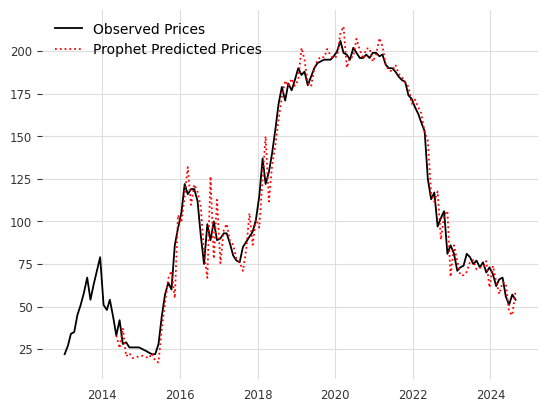

{'MSE': 13093.435802053678, 'MPA (%)': 91.07487585083268, 'F1 Score': 0.31203824424163407, 'MDA (%)': 44.71544715447154}


In [ ]:
start = 16  # Start rolling predictions at index XXX

price_start  = prices[start]
price_change = np.diff(prices)

aligned_dates = lcfs['Date'][1:]

df_price = pd.DataFrame({
    'ds': aligned_dates,
    'y': price_change
})

# Drop any rows with NaN values if necessary
df_price.dropna(inplace=True)

# Perform rolling predictions
predicted_diff = rolling_prophet(df_price, start)

predicted_prices = []
predicted_prices.append(price_start)

for i in range(len(predicted_diff)):
    predicted_prices.append(prices[start+i]+predicted_diff[i])

# Plot original vs. predicted prices
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start:], predicted_prices, label='Prophet Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/Prophet_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start:]))


## (e) LSTM

In LSTM, we also make a rolling prediction.
Using history prices [: current] to predict the current price [current].
We cannot perform batch training in this case since we only have one data input.
Also, we are going to predict the price difference.

We will incorporate other features such as the volume of trading in the next step.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Create a data sequence: [(current_index - num_lags) x num_lags] --> [current_index - num_lags]
# e.g. [[1, 2, 3], [2, 3, 4], [3, 4, 5]] --> [4, 5, 6]

def create_sequences(data, num_lags):
    sequences = []
    targets = []
    for i in range(len(data) - num_lags):
        seq = data[i:i+num_lags]
        target = data[i+num_lags]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer: input size is the single element to input
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define the output layer: output a single value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM: input x and the initial (h0, c0)
        out, _ = self.lstm(x, (h0, c0))
        #print(out)

        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        # print(out)
        # print('-----')

        return out

In [ ]:
def rolling_lstm_predictions(data, num_lags, start_index, num_epochs=10, learning_rate=0.001):
    predictions = []
    #actual_values = []

    criterion = nn.MSELoss()

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for i in range(start_index, len(data)):
        # Prepare training data up to the current index (i-1)
        train_data = data[:i]

        # Create sequences
        X_train, y_train = create_sequences(train_data, num_lags)
#        print(X_train)

        # Convert to PyTorch tensors and reshape
        X_train = torch.from_numpy(X_train).float().unsqueeze(-1).to(device)  # Shape: [samples, num_lags, 1]
        y_train = torch.from_numpy(y_train).float().to(device)

        # Initialize the LSTM model
        model = LSTMModel(input_size=1, hidden_size=32, num_layers=1).to(device)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output.squeeze(), y_train)
            loss.backward()
            optimizer.step()

        # Prepare test input
        x_input = data[i - num_lags:i]
        x_input = torch.from_numpy(x_input).float().unsqueeze(0).unsqueeze(-1).to(device)  # Shape: [1, num_lags, 1]

        # Make prediction
        model.eval()
        with torch.no_grad():
            yhat = model(x_input)
            yhat = yhat.item()

        # Store prediction and actual value
        predictions.append(yhat)
        #actual_values.append(data[i])

    return predictions

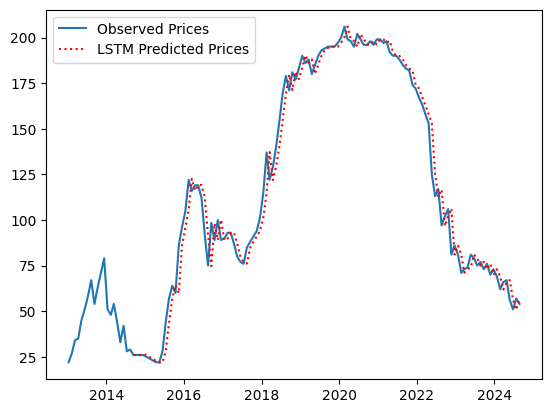

{'MSE': 8625.547948127012, 'MPA (%)': 93.7616798295198, 'F1 Score': 0.3347823836878332, 'MDA (%)': 47.89915966386555}


In [ ]:
# run_rolling predictions

num_lags = 10        # Use previous ? data points
start = 20     # Start from index ?
num_epochs = 10     # Number of epochs for training
learning_rate = 0.001  # Learning rate for the optimizer

price_start  = prices[start]
data = np.diff(prices) # record of price change

# Run rolling predictions
predicted_diff = rolling_lstm_predictions(data, num_lags, start, num_epochs, learning_rate)


# Summarize results
predicted_prices = []
predicted_prices.append(price_start)

for i in range(len(predicted_diff)):
    predicted_prices.append(prices[start+i]+predicted_diff[i])

# Plot original vs. predicted prices
# plt.plot(lcfs['Date'][1:], price_change, label='Observed Prices')
# plt.plot(lcfs['Date'][start:], predicted_diff, label='XGBoost Predicted Prices', color='r', linestyle=':')
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start:], predicted_prices, label='LSTM Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/LSTM_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start:]))


In [ ]:
dates = lcfs['Date'][start:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices
})

df_predictions.to_csv('tech_results/LSTM_pred.csv', index=False)

## (f) Temperal Fusion Transformer

Temperal Fusion Transformer supports the multiple targets and even hetrogeneous targets where some are continuous variables and others categorical, i.e. regression and classification at the same time.

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import torch
import torch.nn as nn
import torch.optim as optim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Transfer to a Dart Timeseries data

In [ ]:
path_to_data = "LCFS_task/LCFS_monthly.csv "
lcfs = pd.read_csv('./LCFS_task/LCFS_monthly.csv', usecols=['Date', 'Price', 'Volume'])
lcfs['Date'] = pd.to_datetime(lcfs['Date'])
prices = lcfs['Price'].values

In [ ]:
df_price = lcfs[['Date', 'Price']]
df_price.head()

df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price.set_index('Date', inplace=True)
df_price.index = pd.to_datetime(df_price.index)
df_price.index = df_price.index.to_period('M')
df_price.index = df_price.index.to_timestamp()

Create covariate:
- In Darts, covariates refer to external data that can be used as inputs to models to help improve forecasts.
- Covariate:
    - Future covariate: are (by definition) covariates known only into the past (e.g. measurements)
        - e.g. daily average forecasted temperatures (known in the future), day of week, month, year, …
    - past covariate: are (by definition) covariates known into the future (e.g., weather forecasts)
        - e.g. daily average measured temperatures (known only in the past), day of week, month, year, …
    - static covariates are (by definition) covariates constant over time (e.g., product IDs)
        - categorical:
            - location of target (country, city, .. name)
            - target identifier: (product ID, store ID, …)
        - numerical:
            - population of target‘s country/market area (assuming it stays constant over the forecasting horizon)
            - average temperature of target‘s region (assuming it stays constant over the forecasting horizon)


### Setup model and start rolling training + prediction

Datts TFT model parameter clearance:

(1) input_chunk_length (int) – Number of time steps in the past to take as a model input (per chunk). Applies to the target series, and past and/or future covariates (if the model supports it). Also called: Encoder length

(2) output_chunk_length (int) – Number of time steps predicted at once (per chunk) by the internal model. Also, the number of future values from future covariates to use as a model input (if the model supports future covariates). It is not the same as forecast horizon n used in predict(), which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. Setting n <= output_chunk_length prevents auto-regression. This is useful when the covariates don’t extend far enough into the future, or to prohibit the model from using future values of past and / or future covariates for prediction (depending on the model’s covariate support). Also called: Decoder length

(3) hidden_size (Union[int, List[int]]) – Hidden state size of the TFT. It is the main hyper-parameter and common across the internal TFT architecture.

(4) lstm_layers (int) – Number of layers for the Long Short Term Memory (LSTM) Encoder and Decoder (1 is a good default).

(5) num_attention_heads (int) – Number of attention heads (4 is a good default)

(6) full_attention (bool) – If False, only attends to previous time steps in the decoder. If True attends to previous, current, and future time steps. Defaults to False.

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html#darts.models.forecasting.tft_model.TFTModel

### Rolling prediction TFT

In [ ]:
def rolling_TFT_predictions(series, covariates, num_lags, start_index, num_samples):

    predictions = []

    for i in range(start_index, len(series)):
        # Split the series set to be train and test, make the prediction starting from start_index
        train, val = series.split_after(i-1)

        transformer = Scaler()
        train_transformed = transformer.fit_transform(train)
        val_transformed = transformer.transform(val)
        series_transformed = transformer.transform(series)

        scaler_covs = Scaler()
        cov_train, cov_val = covariates.split_after(i-1)
        scaler_covs.fit(cov_train)
        covariates_transformed = scaler_covs.transform(covariates)

        # Initialize the TFT model
        my_model = TFTModel(
            input_chunk_length=num_lags,
            output_chunk_length=1,
            hidden_size=16,
            lstm_layers=1,
            num_attention_heads=2,
            dropout=0.2,
            batch_size=8,
            n_epochs=150,
            add_relative_index=False,
            add_encoders=None,
            likelihood=None,
            loss_fn=nn.MSELoss(),
            random_state=42,
            pl_trainer_kwargs={
                "accelerator": device,
                "log_every_n_steps": 1
            },
        )


        # Train the model
        my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)


        # Make prediction
        pred_series = my_model.predict(n=1, num_samples=num_samples)
        pred_price = transformer.inverse_transform(pred_series)

        #median_forecast = pred_series.quantile_timeseries(quantile=0.5)

        # Store prediction and actual value
        price = pred_price.values().flatten()[0]
        predictions.append(price)
        print(f'The {i}-th predicted prices is: {price}')

    return predictions

In [ ]:
# Create a timeSeries object
price_series = TimeSeries.from_series(df_price['Price'])
series = price_series.astype(np.float32)

In [ ]:
# Check seasonality
for m in range(2, 20):
    is_seasonal, period = check_seasonality(series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        break
print("No seasonality detected")

No seasonality detected


In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

In [ ]:
# run_rolling predictions

num_lags    = 10        # Use previous ? data points
start_index = 20        # Start from index ?
num_samples = 1

# Check if MPS (GPU) is available, else fallback to CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Run rolling predictions
predicted_prices = rolling_TFT_predictions(series, covariates, num_lags, start_index, num_samples)

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 20-th predicted prices is: 29.482641220092773


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 21-th predicted prices is: 26.909805297851562


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 22-th predicted prices is: 26.605485916137695


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 23-th predicted prices is: 24.917688369750977


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 24-th predicted prices is: 11.103419303894043


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 25-th predicted prices is: 22.672569274902344


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 26-th predicted prices is: 22.37801170349121


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 27-th predicted prices is: 21.963054656982422


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 28-th predicted prices is: 22.87504768371582


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 29-th predicted prices is: 22.945058822631836


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 30-th predicted prices is: 23.280555725097656


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 31-th predicted prices is: 32.42336654663086


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 32-th predicted prices is: 48.52528762817383


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 33-th predicted prices is: 62.21837615966797


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 34-th predicted prices is: 64.24036407470703


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 35-th predicted prices is: 84.41900634765625


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 36-th predicted prices is: 72.12976837158203


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 37-th predicted prices is: 94.62723541259766


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 38-th predicted prices is: 117.76319885253906


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 39-th predicted prices is: 125.55890655517578


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 40-th predicted prices is: 126.186279296875


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 41-th predicted prices is: 127.94771575927734


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 42-th predicted prices is: 126.95597839355469


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 43-th predicted prices is: 105.58139038085938


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 44-th predicted prices is: 104.56803131103516


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 45-th predicted prices is: 101.49234771728516


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 46-th predicted prices is: 83.5149154663086


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 47-th predicted prices is: 97.40741729736328


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 48-th predicted prices is: 100.77037048339844


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 49-th predicted prices is: 97.48575592041016


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 50-th predicted prices is: 94.20563507080078


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 51-th predicted prices is: 99.48291778564453


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 52-th predicted prices is: 90.016845703125


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 53-th predicted prices is: 85.05083465576172


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 54-th predicted prices is: 88.55274200439453


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 55-th predicted prices is: 80.47801208496094


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 56-th predicted prices is: 83.92649841308594


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 57-th predicted prices is: 82.39582824707031


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 58-th predicted prices is: 84.1639633178711


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 59-th predicted prices is: 86.39725494384766


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 60-th predicted prices is: 87.42137145996094


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 61-th predicted prices is: 97.49278259277344


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 62-th predicted prices is: 91.05940246582031


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 63-th predicted prices is: 99.77496337890625


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 64-th predicted prices is: 106.75952911376953


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 65-th predicted prices is: 137.9954071044922


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 66-th predicted prices is: 144.76068115234375


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 67-th predicted prices is: 156.9884490966797


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 68-th predicted prices is: 171.37550354003906


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 69-th predicted prices is: 172.91957092285156


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 70-th predicted prices is: 183.68898010253906


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 71-th predicted prices is: 184.22523498535156


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 72-th predicted prices is: 180.68663024902344


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 73-th predicted prices is: 181.83584594726562


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 74-th predicted prices is: 185.4759521484375


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 75-th predicted prices is: 187.53672790527344


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 76-th predicted prices is: 189.55706787109375


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 77-th predicted prices is: 189.03973388671875


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 78-th predicted prices is: 191.44479370117188


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 79-th predicted prices is: 192.71820068359375


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 80-th predicted prices is: 188.19024658203125


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 81-th predicted prices is: 192.2864227294922


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 82-th predicted prices is: 193.90185546875


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 83-th predicted prices is: 197.11810302734375


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 84-th predicted prices is: 196.30905151367188


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 85-th predicted prices is: 197.9386444091797


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 86-th predicted prices is: 200.55064392089844


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 87-th predicted prices is: 203.4617462158203


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 88-th predicted prices is: 202.3312530517578


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 89-th predicted prices is: 204.50588989257812


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 90-th predicted prices is: 203.8131103515625


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 91-th predicted prices is: 204.01080322265625


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 92-th predicted prices is: 202.05926513671875


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 93-th predicted prices is: 201.97772216796875


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 94-th predicted prices is: 201.45751953125


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 95-th predicted prices is: 203.54269409179688


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 96-th predicted prices is: 206.47903442382812


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 97-th predicted prices is: 203.93101501464844


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 98-th predicted prices is: 205.95497131347656


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 99-th predicted prices is: 206.44110107421875


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 100-th predicted prices is: 200.3636932373047


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 101-th predicted prices is: 201.09864807128906


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 102-th predicted prices is: 200.446533203125


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 103-th predicted prices is: 203.4315643310547


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 104-th predicted prices is: 202.21438598632812


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 105-th predicted prices is: 198.938720703125


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 106-th predicted prices is: 193.2896728515625


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 107-th predicted prices is: 190.8743438720703


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 108-th predicted prices is: 184.68617248535156


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 109-th predicted prices is: 183.74603271484375


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 110-th predicted prices is: 172.2652130126953


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 111-th predicted prices is: 163.5583038330078


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 112-th predicted prices is: 168.5037078857422


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 113-th predicted prices is: 148.1564483642578


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 114-th predicted prices is: 140.60044860839844


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 115-th predicted prices is: 133.40191650390625


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 116-th predicted prices is: 102.88451385498047


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 117-th predicted prices is: 99.96142578125


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 118-th predicted prices is: 106.99779510498047


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 119-th predicted prices is: 90.48172760009766


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 120-th predicted prices is: 84.08626556396484


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 121-th predicted prices is: 88.06559753417969


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 122-th predicted prices is: 75.45423126220703


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 123-th predicted prices is: 75.9747314453125


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 124-th predicted prices is: 76.6603012084961


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 125-th predicted prices is: 76.25616455078125


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 126-th predicted prices is: 76.91641998291016


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 127-th predicted prices is: 74.6865463256836


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 128-th predicted prices is: 79.89942932128906


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 129-th predicted prices is: 71.65784454345703


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 130-th predicted prices is: 77.21428680419922


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 131-th predicted prices is: 76.16686248779297


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 132-th predicted prices is: 76.51712036132812


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 133-th predicted prices is: 77.56060791015625


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 134-th predicted prices is: 65.17317962646484


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 135-th predicted prices is: 68.25895690917969


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 136-th predicted prices is: 67.62777709960938


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 137-th predicted prices is: 66.72359466552734


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 138-th predicted prices is: 58.549072265625


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

The 139-th predicted prices is: 54.17388916015625


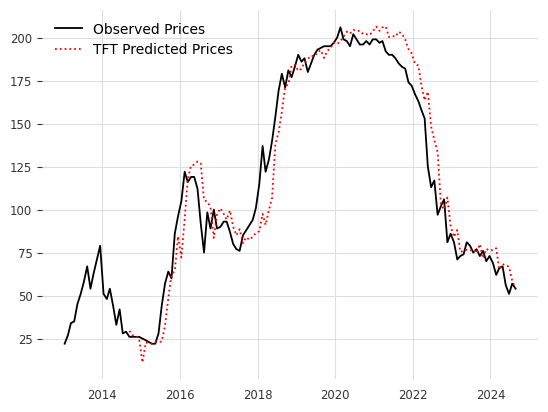

{'MSE': 25768.69253478195, 'MPA (%)': 89.34482247896463, 'F1 Score': 0.36985236985236986, 'MDA (%)': 52.94117647058824}


In [ ]:
# Plot original vs. predicted prices
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start:], predicted_prices, label='TFT Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/TFT_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start_index:]))

In [ ]:
dates = lcfs['Date'][start_index:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices
})

df_predictions.to_csv('tech_results/TFT_pred.csv', index=False)

#### Best result plot here:

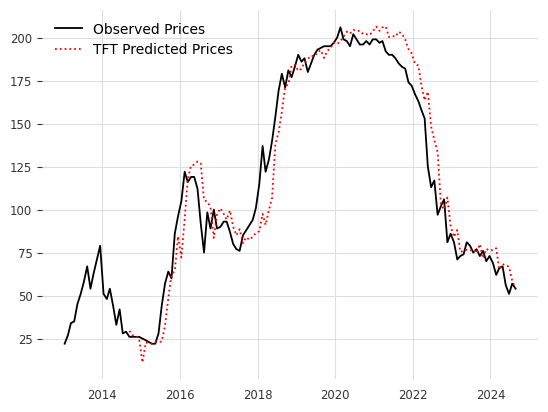

{'MSE': 25768.69253478195, 'MPA (%)': 89.34482247896463, 'F1 Score': 0.36985236985236986, 'MDA (%)': 52.94117647058824}


In [ ]:
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start_index:], predicted_prices, label='TFT Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/TFT_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start_index:]))

In [ ]:
dates = lcfs['Date'][start_index:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices
})

df_predictions.to_csv('tech_results/TFT_pred.csv', index=False)

In [ ]:
df_price.head()

,Price
Date,
2013-01-01,22.0
2013-02-01,27.0
2013-03-01,34.0
2013-04-01,35.0
2013-05-01,45.0


# Technical analysis enhanced (price + volumn)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error, f1_score
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

In [ ]:
path_to_data = "LCFS_task/LCFS_monthly.csv "
lcfs = pd.read_csv('./LCFS_task/LCFS_monthly.csv', usecols=['Date', 'Price', 'Volume'])

lcfs['Date'] = pd.to_datetime(lcfs['Date'])
lcfs

In [ ]:
def evaluation(y_pred, y):
    # Mean standard error
    mse = np.sum((y_pred - y)**2.0)

    # Mean prediction accuracy
    within_threshold = np.abs(y_pred - y) / y
    mpa = np.mean(1 - within_threshold) * 100  # convert to percentage

    true_trend = np.sign(np.diff(y))  # +1 for upward, -1 for downward
    predicted_trend = np.sign(np.diff(y_pred))

    # F-1 Score
    f1 = f1_score(true_trend, predicted_trend, average='macro')

    # movement direction accuracy
    correct_trend = true_trend == predicted_trend
    mda = np.mean(correct_trend) * 100  # convert to percentage

    return {
        'MSE': mse,
        'MPA (%)': mpa,
        'F1 Score': f1,
        'MDA (%)': mda}


In [ ]:
prices = lcfs['Price'].values
volumes = lcfs['Volume'].values

## Kalman Filtering

In [ ]:
from filterpy.kalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# Define Kalman Filter parameters
kf = KalmanFilter(dim_x=4, dim_z=2)  # Four states (price, velocity, volume, volume_change), two observations (price, volume)

# Initial state (price, velocity, volume, volume_change)
kf.x = np.array([prices[0], 5., volumes[0], 0.])  # Initialization

# State transition matrix (how state evolves)
kf.F = np.array([[1., 1., 0., 0.],   # Price evolves based on velocity
                 [0., 1., 0., 0.],   # Velocity remains constant (or linear acceleration model can be used)
                 [0., 0., 1., 1.],   # Volume evolves based on volume_change
                 [0., 0., 0., 1.]])  # Volume_change remains constant

# Observation matrix (how we map the state to the observation)
kf.H = np.array([[1., 0., 0., 0.],  # We observe the price
                 [0., 0., 1., 0.]])  # We observe the volume

# Process uncertainty (noise in the system)
kf.P *= 0  # Initial uncertainty

# Measurement noise
kf.R = np.array([[1., 0.],          # Measurement noise for price
                 [0., 1.]])         # Measurement noise for volume

# Process noise covariance (how much we trust our model)
kf.Q = np.array([[1., 0., 0., 0.],
                 [0., 1., 0., 0.],
                 [0., 0., 1., 0.],
                 [0., 0., 0., 1.]]) * 0.01  # Adjust this factor based on the noise level

# Perform Kalman filtering
predicted_prices = []
predicted_volumes = []

for z_price, z_volume in zip(prices, volumes):
    kf.predict()  # Predict the next state
    predicted_prices.append(kf.x[0])  # Store the predicted price
    predicted_volumes.append(kf.x[2])  # Store the predicted volume
    kf.update([z_price, z_volume])  # Update with the observed price and volume

# Plot original vs. predicted prices and volumes
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'], predicted_prices, label='Kalman Filtering Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.title('Price Prediction')

plt.subplot(2, 1, 2)
plt.plot(lcfs['Date'], volumes, label='Observed Volumes')
plt.plot(lcfs['Date'], predicted_volumes, label='Kalman Filtering Predicted Volumes', color='b', linestyle=':')
plt.legend()
plt.title('Volume Prediction')

plt.tight_layout()
plt.show()

# Evaluate the results
print(f'Price: {evaluation(predicted_prices, prices)}')
print(f'Volume: {evaluation(predicted_volumes, volumes)}')


Kalman fitering does not take Volume as a feature for price prediction instead it treat the volume seperately. In this case, it is not fit.

## ARIMAX

It can take exogenous variables for the prediction:
$$
Y_t = c + \sum^p_{i=1} \phi_i Y_{t-i} + \sum^q_{j=1} \theta_j \epsilon_{t-j} + \sum^{m}_{k=1} \beta_k X_{t-k} + \epsilon_t
$$

Fitting to determine $\phi_i$ and $\beta_k$.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is not stationary; differencing may be needed.")

check_stationarity(np.diff(prices, n=1))
check_stationarity(np.diff(volumes, n=1))


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np

# Prices and Volumes
prices = lcfs['Price'].values
volumes = lcfs['Volume'].values
dates = lcfs['Date']

# Automatically choose the best ARIMA-X parameters
model = auto_arima(
    prices, exogenous=volumes,
    start_p=1, start_q=1, max_p=5, max_q=5,
    seasonal=False, trace=True, error_action='ignore',
    suppress_warnings=True, stepwise=True
)

print(model.summary())

In [ ]:
# Define rolling ARIMA-X function
def rolling_ARIMA_X(prices, volumes, start, p, d, q):
    history_prices = prices[:start]
    history_volumes = volumes[:start]
    predictions = []

    for t in range(start, len(prices)):
        # Fit ARIMA-X model with historical data
        model = ARIMA(history_prices, exog=history_volumes, order=(p, d, q))
        model_fit = model.fit(method_kwargs={"maxiter": 1000})

        # The current exogenous value cannot be known
        current_exog = [history_volumes[t-1]]
        # Make a one-step prediction
        y_pred = model_fit.forecast(exog=current_exog)[0]
        predictions.append(y_pred)

        # Update historical data
        history_prices = np.append(history_prices, prices[t])
        history_volumes = np.append(history_volumes, volumes[t])

    return predictions


In [ ]:
# Parameters for ARIMA-X
start = 16
best_p, best_d, best_q = model.order  # Extract the best parameters from auto_arima

# Perform rolling predictions
predicted_prices = rolling_ARIMA_X(prices, volumes, start, 0, 1, 1)

# Plot original vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, label='Observed Prices')
plt.plot(dates[start:], predicted_prices, label='ARIMA-X Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.title('ARIMA-X Prediction of Prices')
plt.savefig('./tech_results/ARIMA_X_pred.png', dpi=300)
plt.show()

# Evaluate model performance
print("Evaluation:")
print(evaluation(predicted_prices, prices[start:]))

In [ ]:
dates = lcfs['Date'][start:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices
})

df_predictions.to_csv('tech_results/ARIMAX_pred.csv', index=False)

## XGBoost

In [ ]:
def rolling_XGB_with_volume(price_data, volume_data, start, num_lags, n, m):
    x_train = []
    y_train = []

    predictions = []

    # construct the initial prediction
    for i in range(start - num_lags):
        features = np.hstack((price_data[i:i + num_lags],
                              volume_data[i:i + num_lags]))
        x_train.append(features)
        y_train.append(price_data[i+ num_lags])

    x_train = np.array(x_train)
    y_train = np.array(y_train)


    # make a rolling fitting and predictions
    for i in range(start, len(price_data)):
        # Create the test input with lagged features
        x_test = np.hstack((
            price_data[i - num_lags: i],
            volume_data[i - num_lags: i])).reshape(1, -1)
        y_test = price_data[i]  # True price change

        model = XGBRegressor(random_state = 0, n_estimators = n, max_depth = m)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        predictions.append(y_pred.item())

        # Add the predicted point to the training set
        x_train = np.concatenate((x_train, x_test), axis=0)
        y_train = np.append(y_train, y_test)

    return predictions

In [ ]:
start    = 16
num_lags = 15 # Increasing number of lags is useful to increase the score
n_estimators = 20  # Number of trees
max_depth = 20  # Maximum depth of trees

price_start  = prices[start]
price_change = np.diff(prices)
volume_change = np.diff(volumes)

predicted_diff = rolling_XGB_with_volume(price_change, volume_change, start, num_lags, n = n_estimators, m = max_depth)

predicted_prices = []
predicted_prices.append(price_start)

for i in range(len(predicted_diff)):
    predicted_prices.append(prices[start+i]+predicted_diff[i])

plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start:], predicted_prices, label='XGBoost Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/XGBoost+volume_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start:]))

## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Create sequences with both price and volume data
def create_sequences_with_volume(price_data, volume_data, num_lags):
    sequences = []
    targets = []
    for i in range(len(price_data) - num_lags):
        # Stack price and volume changes for each lag
        seq = np.column_stack((price_data[i:i + num_lags], volume_data[i:i + num_lags]))
        target = price_data[i + num_lags]  # Target is the future price change
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define LSTM model (adjusted for multiple input features)
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer: input size is the number of features
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define the output layer: output a single value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM: input x and the initial (h0, c0)
        out, _ = self.lstm(x, (h0, c0))

        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out

def rolling_lstm_predictions_with_volume(price_data, volume_data, num_lags, start_index, num_epochs=10, learning_rate=0.001):
    predictions = []

    criterion = nn.MSELoss()

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for i in range(start_index, len(price_data)):
        # Prepare training data up to the current index (i-1)
        train_price_data = price_data[:i]
        train_volume_data = volume_data[:i]

        # Create sequences
        X_train, y_train = create_sequences_with_volume(train_price_data, train_volume_data, num_lags)

        # Convert to PyTorch tensors and reshape
        X_train = torch.from_numpy(X_train).float().to(device)  # Shape: [samples, num_lags, 2]
        y_train = torch.from_numpy(y_train).float().to(device)

        # Initialize the LSTM model
        model = LSTMModel(input_size=2, hidden_size=32, num_layers=1).to(device)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output.squeeze(), y_train)
            loss.backward()
            optimizer.step()

        # Prepare test input
        x_input = np.column_stack((
            price_data[i - num_lags: i],
            volume_data[i - num_lags: i]
        ))
        x_input = torch.from_numpy(x_input).float().unsqueeze(0).to(device)  # Shape: [1, num_lags, 2]

        # Make prediction
        model.eval()
        with torch.no_grad():
            yhat = model(x_input)
            yhat = yhat.item()

        # Store prediction
        predictions.append(yhat)

    return predictions

In [ ]:
# run_rolling predictions

num_lags = 10        # Use previous ? data points
start = 20     # Start from index ?
num_epochs = 10     # Number of epochs for training
learning_rate = 0.001  # Learning rate for the optimizer

price_start  = prices[start]
price_change = np.diff(prices) # record of price change
volume_change = np.diff(volumes)

# Run rolling predictions
predicted_diff = rolling_lstm_predictions_with_volume(price_change, volume_change, num_lags, start, num_epochs, learning_rate)


# Summarize results
predicted_prices = []
predicted_prices.append(price_start)

for i in range(len(predicted_diff)):
    predicted_prices.append(prices[start+i]+predicted_diff[i])

# Plot original vs. predicted prices
# plt.plot(lcfs['Date'][1:], price_change, label='Observed Prices')
# plt.plot(lcfs['Date'][start:], predicted_diff, label='XGBoost Predicted Prices', color='r', linestyle=':')
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start:], predicted_prices, label='LSTM+volume Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/LSTM+volume_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start:]))

In [ ]:
dates = lcfs['Date'][start:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices
})

df_predictions.to_csv('tech_results/LSTM+volume_pred.csv', index=False)

## TFT

In [ ]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available!")
else:
    print("MPS backend is not available.")


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
def rolling_TFT_predictions(series, past_covariates, future_covariates, num_lags, start_index, num_samples):

    predictions = []

    for i in range(start_index, len(series)):
        # Split the series set to be train and test, make the prediction starting from start_index
        train, val = series.split_after(i-1)

        transformer = Scaler()
        train_transformed = transformer.fit_transform(train)
        val_transformed = transformer.transform(val)
        series_transformed = transformer.transform(series)

        scaler_covs = Scaler()
        cov_train, cov_val = future_covariates.split_after(i-1)
        scaler_covs.fit(cov_train)
        future_covariates_transformed = scaler_covs.transform(future_covariates)

        scaler_pcovs = Scaler()
        pcov_train, pcov_val = past_covariates.split_after(i-1)
        scaler_pcovs.fit(pcov_train)
        past_covariates_transformed = scaler_pcovs.transform(past_covariates)



        # Initialize the TFT model
        my_model = TFTModel(
            input_chunk_length=num_lags,
            output_chunk_length=1,
            hidden_size=16,
            lstm_layers=1,
            num_attention_heads=2,
            dropout=0.2,
            batch_size=8,
            n_epochs=150,
            add_relative_index=False,
            add_encoders=None,
            likelihood=None,
            loss_fn=nn.MSELoss(),
            random_state=42,
            pl_trainer_kwargs={
                "accelerator": device,
                "log_every_n_steps": 1
            },
        )


        # Train the model
        my_model.fit(train_transformed, past_covariates = past_covariates_transformed,
                     future_covariates=future_covariates_transformed, verbose=True)

        # Make prediction
        pred_series = my_model.predict(n=1, num_samples=num_samples)
        pred_price = transformer.inverse_transform(pred_series)

        #median_forecast = pred_series.quantile_timeseries(quantile=0.5)

        # Store prediction and actual value
        price = pred_price.values().flatten()[0]
        predictions.append(price)
        print(f'The {i}-th predicted prices is: {price}')

    return predictions

In [ ]:
# Create a timeSeries object
price_series = TimeSeries.from_series(lcfs['Price'])
series = price_series.astype(np.float32)

In [ ]:
path_to_data = "LCFS_task/LCFS_monthly.csv "
lcfs = pd.read_csv('./LCFS_task/LCFS_monthly.csv', usecols=['Date', 'Price', 'Volume'])
lcfs['Date'] = pd.to_datetime(lcfs['Date'])
prices = lcfs['Price'].values

In [ ]:
df_price = lcfs[['Date', 'Price']]

In [ ]:
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price.set_index('Date', inplace=True)
df_price.index = pd.to_datetime(df_price.index)
df_price.index = df_price.index.to_period('M')
df_price.index = df_price.index.to_timestamp()

In [ ]:
# Create a timeSeries object
price_series = TimeSeries.from_series(df_price['Price'])
series = price_series.astype(np.float32)

In [ ]:
# Future covariate
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

In [ ]:
# Past covariate
df_volume = lcfs[['Date', 'Volume']]
df_volume.set_index('Date', inplace=True)
df_volume.index = pd.to_datetime(df_volume.index)
df_volume.index = df_volume.index.to_period('M')
df_volume.index = df_volume.index.to_timestamp()

volume_series = TimeSeries.from_series(df_volume['Volume'])

past_covariates = volume_series.astype(np.float32)

In [ ]:
# run_rolling predictions

num_lags    = 10        # Use previous ? data points
start_index = 20        # Start from index ?
num_samples = 1

# Check if MPS (GPU) is available, else fallback to CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Run rolling predictions
predicted_prices = rolling_TFT_predictions(series, past_covariates, covariates, num_lags, start_index, num_samples)

In [ ]:
# Plot original vs. predicted prices
plt.plot(lcfs['Date'], prices, label='Observed Prices')
plt.plot(lcfs['Date'][start_index:], predicted_prices, label='TFT Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('./tech_results/TFT+volume_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, prices[start_index:]))

In [ ]:
dates = lcfs['Date'][start_index:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices
})

df_predictions.to_csv('tech_results/TFT+volume_pred.csv', index=False)

In conclusion, adding trading volume does not help with the prediction